In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/RuSportSum/ods_broadcasts_201905301157.csv.zip" /content/ods_broadcasts_201905301157.csv.zip
!cp "/content/drive/MyDrive/RuSportSum/ods_match_news.csv.zip" /content/ods_match_news.csv.zip
!unzip /content/ods_broadcasts_201905301157.csv.zip
!unzip /content/ods_match_news.csv.zip

Archive:  /content/ods_broadcasts_201905301157.csv.zip
  inflating: ods_broadcasts_201905301157.csv  
Archive:  /content/ods_match_news.csv.zip
  inflating: ods_match_news.csv      


In [ ]:
!pip install --quiet transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import nltk
import re

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

import torch
from torch.utils.data import DataLoader

from transformers import AutoTokenizer
from transformers import AutoModel
from datasets import Dataset

from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data_news = pd.read_csv('/content/ods_match_news.csv')
data_news

,id,name,ctime,body,match_id
0,7005921,Зико: &laquo;Задача может быть только одна: пр...,2009-02-18 01:06:26,<p>Главный тренер ЦСКА Зико поделился мыслями ...,18936
1,7005943,Текстовые онлайны матчей &#171;Зенит&#187; &#1...,2009-02-18 01:08:20,<p>Сегодня на Sports.ru дебютируют текстовые о...,18935
2,7005943,Текстовые онлайны матчей &#171;Зенит&#187; &#1...,2009-02-18 01:08:20,<p>Сегодня на Sports.ru дебютируют текстовые о...,18936
3,7006022,Стилян Петров: &laquo;ЦСКА выиграл все матчи в...,2009-02-18 01:21:55,<p>Полузащитник &#171;Астон Виллы&#187; Стилян...,18936
4,7006398,Хиддинк постетит матч &laquo;Астон Виллы&raquo...,2009-02-18 03:17:23,<p>Главный тренер сборной России и &#171;Челси...,18936
...,...,...,...,...,...
92992,1040645221,Петр Чех: Если бы пропустил от Денисова — это ...,2016-06-02 14:44:24,"<p class=""text"">Голкипер сборной Чехии Петр Че...",1095139
92993,1040648050,"Конор Шери: &laquo;Кросби сказал, что выиграет...",2016-06-02 16:17:07,"<p>Форвард <a class=""link-news2tags"" href=""htt...",1104866
92994,1040648436,Сидни Кросби: &laquo;Победным голом мы больше ...,2016-06-02 16:29:35,"<p>Капитан <a class=""link-news2tags"" href=""htt...",1104866
92995,1040653602,Джастин Браун: &laquo;Питтсбург&raquo; все нас...,2016-06-02 19:36:29,<p>Защитник «Сан-Хосе» Джастин Браун оценил хо...,1104866


In [ ]:
data_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92997 entries, 0 to 92996
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        92997 non-null  int64 
 1   name      92997 non-null  object
 2   ctime     92997 non-null  object
 3   body      92995 non-null  object
 4   match_id  92997 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.5+ MB


In [ ]:
# Удалим новости, которые не содержат текста
data_news.dropna(axis=0, how='any', subset=['body'], inplace=True)

In [ ]:
def remove_tags(html):
    soup = BeautifulSoup(html, "html.parser")

    for data in soup(['style', 'script']):
        data.decompose()

    return ' '.join(soup.stripped_strings)

data_news['name'] = data_news['name'].apply(remove_tags)
data_news['body'] = data_news['body'].apply(remove_tags)

<ipython-input-8-8f7201bbcac2>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html, "html.parser")


##### Первый этап анализа новостей

In [ ]:
stop_words = set(stopwords.words('russian'))

counter_name_news = Counter()
for text in data_news['name'].values:
  for word in word_tokenize(text.lower()):
    if word not in stop_words:
      counter_name_news[word] += 1

counter_body_news = Counter()
for text in data_news['body'].values:
  for word in word_tokenize(text.lower()):
    if word not in stop_words:
      counter_body_news[word] += 1

In [ ]:
most_common_name = counter_name_news.most_common(150)
most_common_name

[('«', 128708),
 ('»', 127856),
 (':', 64414),
 (',', 45856),
 ('–', 23759),
 ('.', 22894),
 ('матч', 5343),
 ('матче', 5309),
 ('цска', 4614),
 ('динамо', 4204),
 ('александр', 4108),
 ('другие', 3933),
 ('результаты', 3594),
 ('это', 3555),
 ('гол', 3538),
 ('сергей', 3003),
 ('матча', 2881),
 ('зенит', 2851),
 ('спартак', 2710),
 ('победу', 2703),
 ('очень', 2597),
 ('нам', 2467),
 ('играть', 2426),
 ('россии', 2356),
 ('нхл', 2204),
 ('тур', 2119),
 ('забил', 2097),
 ('ска', 2086),
 ('андрей', 1909),
 ('манчестер', 1819),
 ('локомотив', 1806),
 ('сборной', 1787),
 ('против', 1785),
 ('?', 1715),
 ('кхл', 1704),
 ('нужно', 1634),
 ('россия', 1611),
 ('чемпионат', 1603),
 ('игру', 1599),
 ('челси', 1586),
 ('сегодня', 1586),
 ('чемпионов', 1536),
 ('реал', 1535),
 ('—', 1491),
 ('игре', 1487),
 ('евгений', 1483),
 ('валерий', 1473),
 ('дмитрий', 1442),
 ('владимир', 1425),
 ('матчи', 1419),
 ('барселона', 1414),
 ('игра', 1406),
 ('пенальти', 1398),
 ('анжи', 1397),
 ('финала', 1390)

In [ ]:
most_common_body = counter_body_news.most_common(150)
most_common_body

[(',', 907528),
 ('.', 797734),
 ('»', 413924),
 ('«', 413777),
 ('–', 221646),
 (')', 94116),
 ('(', 93960),
 ('это', 69501),
 ('матча', 61872),
 ('?', 55770),
 ('матче', 46303),
 ('очень', 42436),
 ('матч', 39098),
 ('против', 36292),
 ('россии', 32208),
 (':', 31580),
 ('команда', 30189),
 ('тура', 29865),
 ('сегодня', 29713),
 ('тренер', 28646),
 ('сказал', 28645),
 ('чемпионата', 28020),
 ('—', 27844),
 ('нам', 26897),
 ('сборной', 25513),
 ('команды', 24793),
 ('цска', 24242),
 ('играть', 22997),
 ('главный', 22592),
 ('динамо', 22266),
 ('игру', 21766),
 ('игра', 21426),
 ('игры', 20379),
 ('sports.ru', 20269),
 ('поделился', 20084),
 ('лиги', 19950),
 ('-', 18926),
 ('1', 18338),
 ('думаю', 17792),
 ('2', 17698),
 ('цитирует', 17662),
 ('игре', 17198),
 ('нужно', 17021),
 ('чемпионов', 16582),
 ('3', 16449),
 ('\x96', 16371),
 ('время', 16220),
 ('гол', 16086),
 ('4', 16007),
 ('серии', 14467),
 ('кубка', 13898),
 ('5', 13813),
 ('финала', 13420),
 ('счет', 13396),
 ('премьер-л

In [ ]:
# необходимо удалить символ \x96 из тела новости
data_news['body'] = data_news['body'].apply(lambda x: str(x).replace(' \x96', ""))
# необходимо удалить символ \xa0 из тела новости
data_news['body'] = data_news['body'].apply(lambda x: str(x).replace(u'\xa0', u' '))

In [ ]:
data_news

,id,name,ctime,body,match_id
0,7005921,Зико: «Задача может быть только одна: пройти в...,2009-02-18 01:06:26,Главный тренер ЦСКА Зико поделился мыслями о п...,18936
1,7005943,"Текстовые онлайны матчей «Зенит» – «Штутгарт»,...",2009-02-18 01:08:20,Сегодня на Sports.ru дебютируют текстовые онла...,18935
2,7005943,"Текстовые онлайны матчей «Зенит» – «Штутгарт»,...",2009-02-18 01:08:20,Сегодня на Sports.ru дебютируют текстовые онла...,18936
3,7006022,Стилян Петров: «ЦСКА выиграл все матчи в этом ...,2009-02-18 01:21:55,Полузащитник «Астон Виллы» Стилян Петров подел...,18936
4,7006398,Хиддинк постетит матч «Астон Виллы» и ЦСКА,2009-02-18 03:17:23,Главный тренер сборной России и «Челси» Гус Хи...,18936
...,...,...,...,...,...
92992,1040645221,Петр Чех: Если бы пропустил от Денисова — это ...,2016-06-02 14:44:24,Голкипер сборной Чехии Петр Чех после победы в...,1095139
92993,1040648050,"Конор Шери: «Кросби сказал, что выиграет вбрас...",2016-06-02 16:17:07,Форвард «Питтсбурга» Конор Шери прокомментиров...,1104866
92994,1040648436,Сидни Кросби: «Победным голом мы больше обязан...,2016-06-02 16:29:35,Капитан «Питтсбурга» Сидни Кросби прокомментир...,1104866
92995,1040653602,Джастин Браун: «Питтсбург» все наступал и наст...,2016-06-02 19:36:29,Защитник «Сан-Хосе» Джастин Браун оценил ход с...,1104866


In [ ]:
"""
tokenizer = nltk.data.load('tokenizers/punkt/PY3/russian.pickle')

def get_start_body(example):
  sentences = tokenizer.tokenize(example)
  return ' '.join(sentences[0:2])

data_news['part_body'] = data_news['body'] .apply(get_start_body)
"""

"\ntokenizer = nltk.data.load('tokenizers/punkt/PY3/russian.pickle')\n\ndef get_start_body(example):\n  sentences = tokenizer.tokenize(example)\n  return ' '.join(sentences[0:2])\n\ndata_news['part_body'] = data_news['body'] .apply(get_start_body)\n"

In [ ]:
data_news['length_news_name'] = data_news['name'].apply(lambda x: len(x.split()))
data_news['length_body'] = data_news['body'].apply(lambda x: len(x.split()))
data_news[['length_news_name', 'length_body']].describe()

,length_news_name,length_body
count,92995.000000,92995.000000
mean,10.567256,113.735502
std,3.139614,74.275862
min,3.000000,0.000000
25%,8.000000,63.000000
50%,10.000000,94.000000
75%,12.000000,142.000000
max,28.000000,1249.000000


<Axes: xlabel='length_body'>

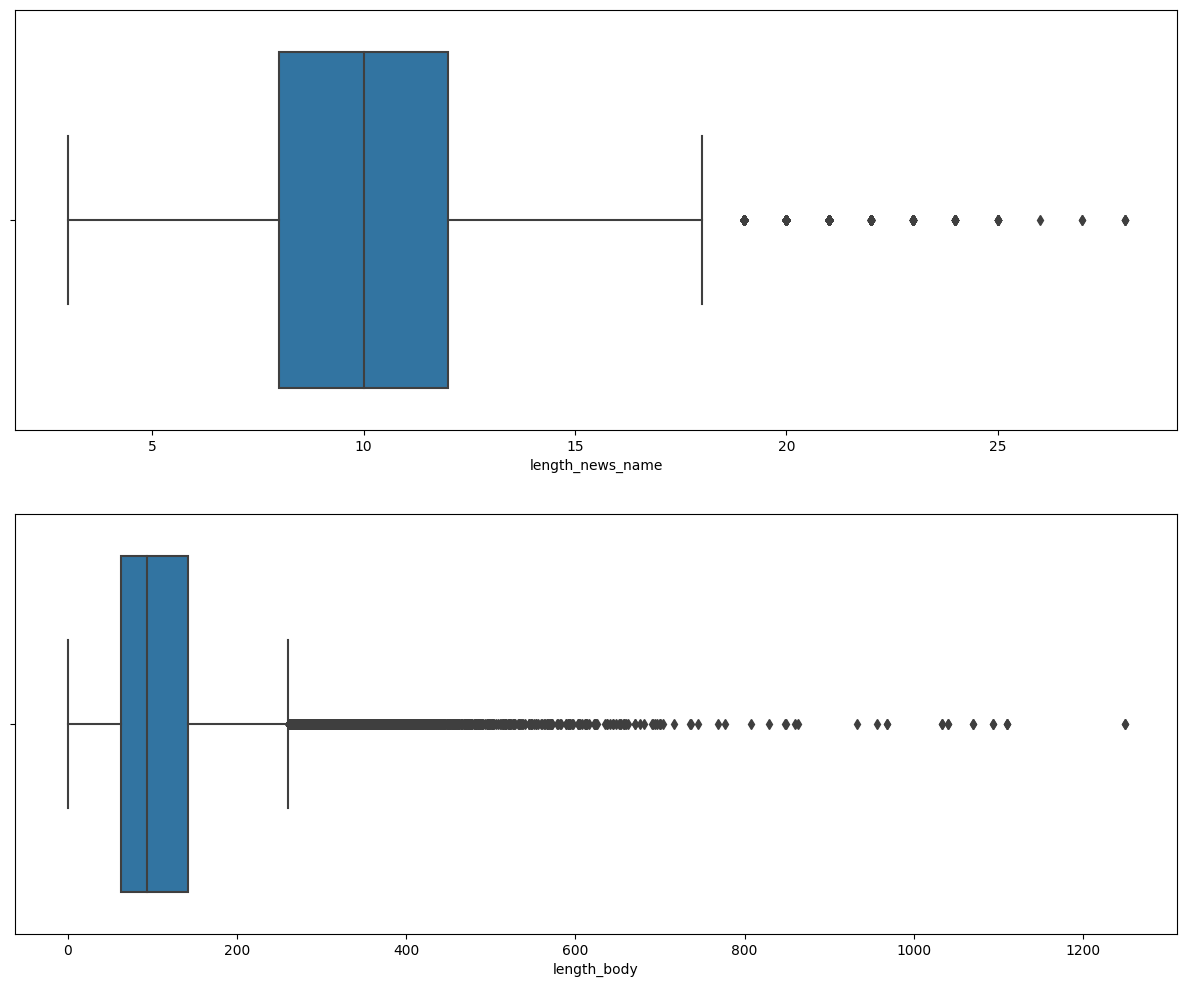

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

sns.boxplot(ax=axes[0], x='length_news_name', data=data_news)
sns.boxplot(ax=axes[1], x='length_body', data=data_news)

In [ ]:
data_news = data_news[data_news['length_body'] > 1]

data_news[['length_news_name', 'length_body']].describe()

,length_news_name,length_body
count,92994.000000,92994.000000
mean,10.567273,113.736725
std,3.139626,74.275325
min,3.000000,2.000000
25%,8.000000,63.000000
50%,10.000000,94.000000
75%,12.000000,142.000000
max,28.000000,1249.000000


In [ ]:
# найдем новости, где в заголовке есть цитата
data_news['no_contain_quote'] = data_news['name'].apply(lambda x: 0 if re.search(r'[а-яa-z"»]+:', x) is not None else 1)
# найдем новости, где есть фраза "другие результаты", что в большинстве случаев указывает на то, что в теле новости много результатов разных матчей
data_news['no_contain_many_results'] = data_news['name'].apply(lambda x: 0 if "другие результаты" in x else 1)

<ipython-input-21-e3e79066008c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_news['no_contain_quote'] = data_news['name'].apply(lambda x: 0 if re.search(r'[а-яa-z"»]+:', x) is not None else 1)
<ipython-input-21-e3e79066008c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_news['no_contain_many_results'] = data_news['name'].apply(lambda x: 0 if "другие результаты" in x else 1)


In [ ]:
data_news_1 = data_news[(data_news['no_contain_quote'] == 1) & (data_news['no_contain_many_results'] == 1)]
data_news_1

,id,name,ctime,body,match_id,length_news_name,length_body,no_contain_quote,no_contain_many_results
1,7005943,"Текстовые онлайны матчей «Зенит» – «Штутгарт»,...",2009-02-18 01:08:20,Сегодня на Sports.ru дебютируют текстовые онла...,18935,18,110,1,1
2,7005943,"Текстовые онлайны матчей «Зенит» – «Штутгарт»,...",2009-02-18 01:08:20,Сегодня на Sports.ru дебютируют текстовые онла...,18936,18,110,1,1
4,7006398,Хиддинк постетит матч «Астон Виллы» и ЦСКА,2009-02-18 03:17:23,Главный тренер сборной России и «Челси» Гус Хи...,18936,7,57,1,1
18,7010916,Кубок УЕФА. 1/16 финала. Первые матчи. «Зенит»...,2009-02-18 15:57:00,Кубок УЕФА 1/16 финала Первые матчи,18935,15,6,1,1
19,7010916,Кубок УЕФА. 1/16 финала. Первые матчи. «Зенит»...,2009-02-18 15:57:00,Кубок УЕФА 1/16 финала Первые матчи,18936,15,6,1,1
...,...,...,...,...,...,...,...,...,...
92959,1040626745,НХЛ. «Питтсбург» – «Сан-Хосе». Ньето заменит З...,2016-06-01 20:52:37,Нападающий «Сан-Хосе» Мэттью Ньето войдет в со...,1104866,10,72,1,1
92976,1040636713,НХЛ. Форвард «Питтсбурга» Шери забил первый по...,2016-06-02 08:20:10,Во втором матче финала Кубка Стэнли «Питтсбург...,1104866,10,76,1,1
92977,1040636981,НХЛ. Мюррей одержал 13-ю победу в дебютном пле...,2016-06-02 08:41:16,Во втором матче финала Кубка Стэнли «Питтсбург...,1104866,12,63,1,1
92978,1040637171,НХЛ. Звено Хагелин – Бонино – Кессел суммарно ...,2016-06-02 08:52:19,Во втором матче финала Кубка Стэнли «Питтсбург...,1104866,15,76,1,1


##### Второй этап анализа новостей

In [ ]:
counter_name_news = Counter()
for text in data_news_1['name'].values:
  for word in word_tokenize(text.lower()):
    if word not in stop_words:
      counter_name_news[word] += 1

counter_body_news = Counter()
for text in data_news_1['body'].values:
  for word in word_tokenize(text.lower()):
    if word not in stop_words:
      counter_body_news[word] += 1

In [ ]:
most_common_name = counter_name_news.most_common(150)
most_common_name

[('«', 32722),
 ('»', 32717),
 ('–', 16111),
 ('.', 13857),
 (',', 4875),
 ('матч', 2945),
 ('матче', 2777),
 ('гол', 2089),
 ('цска', 1832),
 ('динамо', 1773),
 ('нхл', 1680),
 ('забил', 1613),
 ('победу', 1545),
 ('зенит', 1395),
 ('матча', 1278),
 ('спартак', 1233),
 ('получил', 1222),
 ('россия', 1192),
 ('манчестер', 1115),
 ('барселона', 1073),
 ('реал', 1042),
 ('принес', 998),
 ('локомотив', 895),
 ('травму', 887),
 ('финала', 879),
 ('челси', 854),
 ('кхл', 844),
 ('россии', 816),
 ('ска', 816),
 ('стал', 774),
 ('сыграет', 767),
 ('матчи', 748),
 ('арсенал', 735),
 ('кубок', 721),
 ('сити', 719),
 ('впервые', 715),
 ('минут', 701),
 ('рубин', 686),
 ('чемпионов', 686),
 ('из-за', 641),
 ('первых', 633),
 ('составе', 631),
 ('дубль', 628),
 ('анжи', 592),
 ('—', 585),
 ('лиги', 577),
 ('подряд', 575),
 ('стали', 558),
 ('первый', 545),
 ('сборной', 536),
 ('против', 526),
 ('юнайтед', 513),
 ('пропустит', 504),
 ('болельщиков', 501),
 ('известны', 496),
 ('составы', 489),
 ('к

In [ ]:
most_common_body = counter_body_news.most_common(150)
most_common_body

[(',', 119542),
 ('.', 107813),
 ('«', 97698),
 ('»', 97670),
 ('–', 30861),
 (')', 29152),
 ('(', 29005),
 ('матча', 16196),
 ('матче', 12974),
 (':', 12169),
 ('sports.ru', 10269),
 ('матч', 10207),
 ('чемпионата', 9247),
 ('тура', 9001),
 ('против', 7694),
 ('онлайн-трансляцию', 7564),
 ('россии', 7495),
 ('лиги', 6114),
 ('сегодня', 5309),
 ('напомним', 4903),
 ('кубка', 4834),
 ('цска', 4801),
 ('сборной', 4752),
 ('динамо', 4647),
 ('чемпионов', 4417),
 ('сообщает', 4284),
 ('финала', 4189),
 ('премьер-лиги', 4155),
 ('время', 4049),
 ('статистика', 3985),
 ('1', 3850),
 ('серии', 3847),
 ('минуте', 3698),
 ('матчей', 3575),
 ('2', 3516),
 ('текстовую', 3374),
 ('провел', 3357),
 ('это', 3315),
 ('манчестер', 3291),
 ('3', 3250),
 ('нападающий', 3243),
 ('таблица', 3161),
 ('0', 3153),
 ('получил', 3145),
 ('счет', 3078),
 ('форвард', 3044),
 ('времени', 3032),
 ('статистику', 3012),
 ('4', 2935),
 ('команды', 2930),
 ('московскому', 2772),
 ('—', 2734),
 ('забил', 2706),
 ('кхл'

In [ ]:
data_news_1['no_contain_bookmaker'] = data_news_1['body'].apply(lambda x: 0 if re.search(r'[Бб]укмекер', x) is not None else 1)

<ipython-input-26-61631e98bed9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_news_1['no_contain_bookmaker'] = data_news_1['body'].apply(lambda x: 0 if re.search(r'[Бб]укмекер', x) is not None else 1)


In [ ]:
data_news_1['no_contain_text_translation'] = data_news_1['body'].apply(lambda x: 0 if re.search(r'текстовые', x) is not None else 1)

<ipython-input-27-74fbed65f509>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_news_1['no_contain_text_translation'] = data_news_1['body'].apply(lambda x: 0 if re.search(r'текстовые', x) is not None else 1)


In [ ]:
data_news_1['no_contain_team'] = data_news_1['name'].apply(lambda x: 0 if re.search(r'[Сс]оставы', x) is not None else 1)

<ipython-input-28-51d0b1ff89c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_news_1['no_contain_team'] = data_news_1['name'].apply(lambda x: 0 if re.search(r'[Сс]оставы', x) is not None else 1)


In [ ]:
data_news_2 = data_news_1[(data_news_1['no_contain_bookmaker'] == 1) & (data_news_1['no_contain_team'] == 1) & (data_news_1['no_contain_text_translation'] == 1)]
data_news_2

,id,name,ctime,body,match_id,length_news_name,length_body,no_contain_quote,no_contain_many_results,no_contain_bookmaker,no_contain_text_translation,no_contain_team
4,7006398,Хиддинк постетит матч «Астон Виллы» и ЦСКА,2009-02-18 03:17:23,Главный тренер сборной России и «Челси» Гус Хи...,18936,7,57,1,1,1,1,1
18,7010916,Кубок УЕФА. 1/16 финала. Первые матчи. «Зенит»...,2009-02-18 15:57:00,Кубок УЕФА 1/16 финала Первые матчи,18935,15,6,1,1,1,1,1
19,7010916,Кубок УЕФА. 1/16 финала. Первые матчи. «Зенит»...,2009-02-18 15:57:00,Кубок УЕФА 1/16 финала Первые матчи,18936,15,6,1,1,1,1,1
20,7012099,«Зенит» и «Штутгарт» могут сыграть красным мяч...,2009-02-18 17:33:12,Делегат УЕФА Зуне Хелльстремер сегодня утром о...,18935,12,99,1,1,1,1,1
21,7012532,В кассах «Петровского» осталось 1500 билетов н...,2009-02-18 18:03:35,"Как стало известно корреспонденту Sports.ru, н...",18935,11,59,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
92959,1040626745,НХЛ. «Питтсбург» – «Сан-Хосе». Ньето заменит З...,2016-06-01 20:52:37,Нападающий «Сан-Хосе» Мэттью Ньето войдет в со...,1104866,10,72,1,1,1,1,1
92976,1040636713,НХЛ. Форвард «Питтсбурга» Шери забил первый по...,2016-06-02 08:20:10,Во втором матче финала Кубка Стэнли «Питтсбург...,1104866,10,76,1,1,1,1,1
92977,1040636981,НХЛ. Мюррей одержал 13-ю победу в дебютном пле...,2016-06-02 08:41:16,Во втором матче финала Кубка Стэнли «Питтсбург...,1104866,12,63,1,1,1,1,1
92978,1040637171,НХЛ. Звено Хагелин – Бонино – Кессел суммарно ...,2016-06-02 08:52:19,Во втором матче финала Кубка Стэнли «Питтсбург...,1104866,15,76,1,1,1,1,1


##### Третий этап анализа новостей

In [ ]:
counter_name_news = Counter()
for text in data_news_2['name'].values:
  for word in word_tokenize(text.lower()):
    if word not in stop_words:
      counter_name_news[word] += 1

counter_body_news = Counter()
for text in data_news_2['body'].values:
  for word in word_tokenize(text.lower()):
    if word not in stop_words:
      counter_body_news[word] += 1

In [ ]:
most_common_name = counter_name_news.most_common(150)
most_common_name

[('«', 30913),
 ('»', 30907),
 ('–', 15169),
 ('.', 13205),
 (',', 4788),
 ('матч', 2903),
 ('матче', 2673),
 ('гол', 2081),
 ('цска', 1741),
 ('динамо', 1721),
 ('нхл', 1659),
 ('забил', 1603),
 ('победу', 1519),
 ('зенит', 1316),
 ('получил', 1208),
 ('матча', 1184),
 ('спартак', 1175),
 ('россия', 1164),
 ('манчестер', 1026),
 ('барселона', 1002),
 ('принес', 998),
 ('реал', 982),
 ('травму', 877),
 ('финала', 865),
 ('локомотив', 858),
 ('кхл', 840),
 ('ска', 803),
 ('россии', 788),
 ('челси', 773),
 ('стал', 769),
 ('сыграет', 759),
 ('матчи', 743),
 ('кубок', 718),
 ('впервые', 710),
 ('минут', 699),
 ('чемпионов', 665),
 ('сити', 662),
 ('арсенал', 659),
 ('из-за', 634),
 ('первых', 630),
 ('составе', 629),
 ('дубль', 628),
 ('рубин', 627),
 ('подряд', 570),
 ('—', 561),
 ('лиги', 551),
 ('первый', 543),
 ('анжи', 543),
 ('сборной', 524),
 ('против', 511),
 ('пропустит', 499),
 ('болельщиков', 490),
 ('юнайтед', 477),
 ('счет', 456),
 ('плей-офф', 451),
 ('сыграют', 449),
 ('рос

In [ ]:
most_common_body = counter_body_news.most_common(150)
most_common_body

[(',', 105464),
 ('.', 103041),
 ('«', 91620),
 ('»', 91595),
 ('–', 28455),
 (')', 28155),
 ('(', 28008),
 ('матча', 15546),
 ('матче', 12646),
 (':', 10664),
 ('sports.ru', 9499),
 ('матч', 9369),
 ('чемпионата', 8842),
 ('тура', 8579),
 ('против', 7524),
 ('онлайн-трансляцию', 7146),
 ('россии', 7143),
 ('лиги', 5867),
 ('сегодня', 5041),
 ('кубка', 4732),
 ('сборной', 4634),
 ('цска', 4523),
 ('динамо', 4467),
 ('напомним', 4447),
 ('чемпионов', 4220),
 ('сообщает', 4208),
 ('финала', 4082),
 ('премьер-лиги', 4025),
 ('статистика', 3980),
 ('время', 3911),
 ('1', 3815),
 ('серии', 3811),
 ('минуте', 3672),
 ('2', 3498),
 ('матчей', 3372),
 ('провел', 3347),
 ('текстовую', 3249),
 ('это', 3239),
 ('3', 3231),
 ('нападающий', 3209),
 ('таблица', 3160),
 ('0', 3151),
 ('получил', 3114),
 ('счет', 3053),
 ('форвард', 3028),
 ('манчестер', 3003),
 ('статистику', 2986),
 ('4', 2916),
 ('команды', 2814),
 ('времени', 2759),
 ('забил', 2688),
 ('кхл', 2670),
 ('гол', 2651),
 ('защитник', 2

In [ ]:
result_news = data_news_2.drop(['length_news_name', 'length_body', 'no_contain_quote', 'no_contain_many_results', 'no_contain_bookmaker', 'no_contain_text_translation', 'no_contain_team'], axis=1)
result_news

,id,name,ctime,body,match_id
4,7006398,Хиддинк постетит матч «Астон Виллы» и ЦСКА,2009-02-18 03:17:23,Главный тренер сборной России и «Челси» Гус Хи...,18936
18,7010916,Кубок УЕФА. 1/16 финала. Первые матчи. «Зенит»...,2009-02-18 15:57:00,Кубок УЕФА 1/16 финала Первые матчи,18935
19,7010916,Кубок УЕФА. 1/16 финала. Первые матчи. «Зенит»...,2009-02-18 15:57:00,Кубок УЕФА 1/16 финала Первые матчи,18936
20,7012099,«Зенит» и «Штутгарт» могут сыграть красным мяч...,2009-02-18 17:33:12,Делегат УЕФА Зуне Хелльстремер сегодня утром о...,18935
21,7012532,В кассах «Петровского» осталось 1500 билетов н...,2009-02-18 18:03:35,"Как стало известно корреспонденту Sports.ru, н...",18935
...,...,...,...,...,...
92959,1040626745,НХЛ. «Питтсбург» – «Сан-Хосе». Ньето заменит З...,2016-06-01 20:52:37,Нападающий «Сан-Хосе» Мэттью Ньето войдет в со...,1104866
92976,1040636713,НХЛ. Форвард «Питтсбурга» Шери забил первый по...,2016-06-02 08:20:10,Во втором матче финала Кубка Стэнли «Питтсбург...,1104866
92977,1040636981,НХЛ. Мюррей одержал 13-ю победу в дебютном пле...,2016-06-02 08:41:16,Во втором матче финала Кубка Стэнли «Питтсбург...,1104866
92978,1040637171,НХЛ. Звено Хагелин – Бонино – Кессел суммарно ...,2016-06-02 08:52:19,Во втором матче финала Кубка Стэнли «Питтсбург...,1104866


In [ ]:
result_news.to_csv('result_news.csv', index=False, encoding='utf-8')

In [ ]:
!cp "/content/result_news.csv" "/content/drive/MyDrive/RuSportSum/result_news.csv"